In [1]:
#@title Init all {display-mode: "form"}

import os

if not os.path.exists('MLPTTS'):

  %tensorflow_version 1.x
  %matplotlib inline
  !pip install tqdm -q
  !pip install gdown
  !pip install -q tacotron

  import sys
  import time
  import matplotlib
  import matplotlib.pylab as plt
  import gdown
  import IPython.display as ipd
  import numpy as np
  import torch
  import json
  from IPython.display import clear_output
  from os.path import exists, join, basename, splitext
  from tqdm.notebook import tqdm
  from tacotron import load_cmudict

  git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
  project_name = splitext(basename(git_repo_url))[0]

  !git clone -q --recursive {git_repo_url}
  !git clone -q --recursive https://github.com/SortAnon/hifi-gan
  !pip install -q librosa unidecode

  sys.path.append(project_name)
  sys.path.append('hifi-gan')
      
  from hparams import create_hparams
  from model import Tacotron2
  from layers import TacotronSTFT
  from audio_processing import griffin_lim
  from text import text_to_sequence

  from meldataset import MAX_WAV_VALUE
  from models import Generator

  HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

  d = 'https://drive.google.com/uc?id='

  # Setup Pronounciation Dictionary
  thisdict = load_cmudict()

  graph_width = 900
  graph_height = 360

  previous_tt2_id = ''
  previous_gan = ''


def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
  fig, axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
      axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                  interpolation='none', cmap='inferno')
  fig.canvas.draw()
  plt.show()


def has_MMI(STATE_DICT):
  return any(True for x in STATE_DICT.keys() if "mi." in x)

def get_Tactron2(MODEL_ID):
  # Download Tacotron2
  tacotron2_pretrained_model = 'MLPTTS'
  gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
  if not exists(tacotron2_pretrained_model):
      raise Exception("Tacotron2 model failed to download!")
  # Load Tacotron2 and Config
  hparams = create_hparams()
  hparams.sampling_rate = 22050
  hparams.max_decoder_steps = 3000 # Max Duration
  hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
  model = Tacotron2(hparams)
  state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
  if has_MMI(state_dict):
      raise Exception("ERROR: This notebook does not currently support MMI models.")
  model.load_state_dict(state_dict)
  _ = model.cuda().eval().half()
  return model, hparams

def get_model_id(name):
  models = {
      'alex 120_8': '1lyo91yhMNQXvt00_5Xel7EwoDc14II7w',
      'ljspeech_1250_100_no_noise': '13UwZynkmCT25E3Vz8z-FvssBtcEqVTAr',
      'ljspeech_1250_100_noised': '1riRPDdShgER0OACPYfP3kBQac11ro1-t',
  }
  return models.get(name)

def get_waveglow():
  waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='int16')
  waveglow = waveglow.remove_weightnorm(waveglow)
  waveglow = waveglow.to('cuda')
  waveglow.eval().half()
  return waveglow

def infer(taco_model, sequence):
  mel_outputs, mel_outputs_postnet, _, alignments = taco_model.inference(sequence)
  plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
            alignments.float().data.cpu().numpy()[0].T))
  

  y_g_hat = gan.infer(mel_outputs_postnet)
  
  audio = y_g_hat.squeeze()
  audio = audio * MAX_WAV_VALUE
  ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))

def end_to_end_infer(text):
  for i in [x for x in text.split("\n") if len(x)]:
    
    if i[-1] != ";": i=i+";"
    
    %matplotlib inline
    with torch.no_grad(): # save VRAM by not including gradients
      sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
      sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
      
      infer(model, sequence)
    

clear_output()

Enter/Paste your text.
--------------------------------------------------
Hello my name is Yaroslaav and today i will present you my diploma. The voice you hear is completely generated
Hello my name is Yaroslaav and today i will present you my diploma. The voice you hear is completely generated


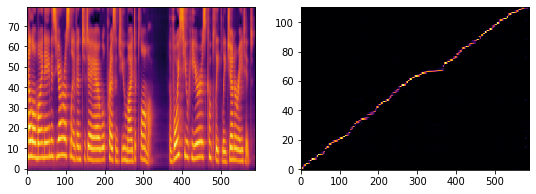

--------------------------------------------------


In [ ]:
#@title If you want to use your own model, insert it's url and check field "use_my_own_model" {display-mode: "form"}

model_url = 'https://drive.google.com/file/d/1_BIuhmoNtwgsyMzAgQHA8eUCWISyB1pD/view?usp=sharing' #@param {type:"string"}
use_my_own_model = False #@param {type:"boolean"}
model_name = "ljspeech_1250_100_noised"  #@param ['ljspeech_1250_100_no_noise', 'ljspeech_1250_100_noised', 'alex 120_8']
steps = 1000
stop_threshold = 0.27

model_url = model_url.lstrip("https://drive.google.com/file/d/")
model_url = model_url.rstrip("/view?usp=sharing")

if use_my_own_model:
  Tacotron_model = model_url
else:
  Tacotron_model = get_model_id(model_name)

TACOTRON2_ID = Tacotron_model

gan = get_waveglow()

if previous_tt2_id != TACOTRON2_ID:
  print("Updating Model 1")
  model, hparams = get_Tactron2(TACOTRON2_ID)
  model.decoder.max_decoder_steps = steps
  model.decoder.gate_threshold = stop_threshold
  previous_tt2_id = TACOTRON2_ID

clear_output()

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        # clear_output()
        print(line)
        if line == "":
            continue
        end_to_end_infer(line)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break